In [4]:
import numpy as np
import os
import pandas as pd
import xml.etree.ElementTree as etree
import copy 
import datetime 
data_path = '../../../code_data/ohio/ohio_raw_data/'
save_path = '../../../code_data/ohio/coldstart_fl'
pid_list_2018 = [559, 563, 570, 575, 588, 591]
pid_list_2020 = [540, 544, 552, 567, 584, 596]
pid_list = pid_list_2018 + pid_list_2020
attri_list = [
    'glucose_level',
    'finger_stick',
    'basal',
    'temp_basal',
    'bolus',
    'meal',
    'sleep',
    'work',
    'stressors',
    'hypo_event',
    'illness',
    'exercise',
    'basis_heart_rate',
    'basis_gsr',
    'basis_skin_temperature',
    'basis_air_temperature',
    'basis_steps',
    'basis_sleep',
    'acceleration',
]

In [5]:

# load data from xml files
def load_xml(is_train):
    pid_attri2data = {}
    ending = '-ws-training.xml' if is_train else '-ws-testing.xml'

    # loop for pids
    for pid in pid_list:
        xml_path = os.path.join(data_path, f'{pid}' + ending)
        tree = etree.parse(xml_path)
        root = tree.getroot()
        # loop for attributes
        for attri in attri_list:
            try:
                temp = [event.attrib for event in root.find(attri).findall('event')]
            except:
                continue
            if len(temp) == 0:
                continue
            # change data to dataframe
            temp_pd = pd.DataFrame(temp)
            for col in temp_pd.columns:
                try:
                    temp_pd[col] = pd.to_datetime(temp_pd[col], dayfirst=True)
                except:
                    try:
                        temp_pd[col] = temp_pd[col].astype(float)
                    except:
                        pass
            rename_cols = {}
            for col in temp_pd.columns:
                rename_cols[col] = f'{attri}_{col}'
            temp_pd.rename(columns=rename_cols, inplace=True)

            if attri == 'basis_sleep':
                temp_pd.rename(columns={f'{attri}_tbegin': f'{attri}_ts_begin', f'{attri}_tend': f'{attri}_ts_end'}, inplace=True)
            
            # this part is time consuming
            if attri in ['glucose_level', 'finger_stick', 'basal', 
            'meal', 'stressors', 'exercise', 'basis_gsr',
             'basis_skin_temperature', 'acceleration', 'basis_heart_rate', 'basis_air_temperature', 'basis_steps']:
                temp_pd.set_index(f'{attri}_ts', inplace=True)
            elif attri in ['hypo_event']:
                pid_attri2data[(pid, attri)] = temp_pd
                continue
            else:

                temp_pd.set_index(f'{attri}_ts_begin', inplace=True)


            pid_attri2data[(pid, attri)] = temp_pd
    return pid_attri2data

In [6]:
# load training data
train_pid_attri2data = load_xml(is_train=True)

# load testing data
test_pid_attri2data = load_xml(is_train=False)

In [7]:
# count the number of attribute which actually exists in the dataset
count_attri = {}
count_samples = {}
for k in train_pid_attri2data:
    pid, attri = k
    if attri not in count_attri:
        count_attri[attri] = 0
        count_samples[attri] = 0
    count_attri[attri] += 1
    count_samples[attri] += len(train_pid_attri2data[k])

for attri in count_attri:
    print(f'{count_attri[attri]} people have {attri}; each people have around {count_samples[attri]/count_attri[attri]:.2f} samples')

12 people have glucose_level; each people have around 11232.50 samples
12 people have finger_stick; each people have around 328.67 samples
12 people have basal; each people have around 86.50 samples
12 people have temp_basal; each people have around 39.42 samples
12 people have bolus; each people have around 251.92 samples
12 people have meal; each people have around 149.42 samples
11 people have sleep; each people have around 36.55 samples
8 people have work; each people have around 21.88 samples
4 people have stressors; each people have around 1.50 samples
9 people have hypo_event; each people have around 13.22 samples
8 people have illness; each people have around 1.38 samples
10 people have exercise; each people have around 18.70 samples
6 people have basis_heart_rate; each people have around 12329.17 samples
12 people have basis_gsr; each people have around 25099.25 samples
12 people have basis_skin_temperature; each people have around 25111.25 samples
6 people have basis_air_temp

In [8]:
valid_attri_list = list(count_attri.keys())

In [9]:
valid_attri_list

['glucose_level',
 'finger_stick',
 'basal',
 'temp_basal',
 'bolus',
 'meal',
 'sleep',
 'work',
 'stressors',
 'hypo_event',
 'illness',
 'exercise',
 'basis_heart_rate',
 'basis_gsr',
 'basis_skin_temperature',
 'basis_air_temperature',
 'basis_steps',
 'basis_sleep',
 'acceleration']

In [10]:
for pid in pid_list:
    if (pid, 'hypo_event') in train_pid_attri2data:
        train_pid_attri2data[(pid, 'hypo_event')]['hypo_event_'] = train_pid_attri2data[(pid, 'hypo_event')].loc[:, 'hypo_event_ts']
        train_pid_attri2data[(pid, 'hypo_event')].set_index('hypo_event_ts', inplace=True)
    if (pid, 'hypo_event') in test_pid_attri2data:
        test_pid_attri2data[(pid, 'hypo_event')]['hypo_event_'] = test_pid_attri2data[(pid, 'hypo_event')].loc[:, 'hypo_event_ts']
        test_pid_attri2data[(pid, 'hypo_event')].set_index('hypo_event_ts', inplace=True)

In [11]:
pid = 588
train_pid_attri2data[(pid, 'hypo_event')]

,hypo_event_
hypo_event_ts,
2021-08-31 20:12:00,2021-08-31 20:12:00
2021-09-03 17:07:00,2021-09-03 17:07:00
2021-09-04 19:56:00,2021-09-04 19:56:00
2021-09-06 11:47:00,2021-09-06 11:47:00
2021-09-06 20:47:00,2021-09-06 20:47:00
2021-09-10 19:46:00,2021-09-10 19:46:00
2021-09-13 20:12:00,2021-09-13 20:12:00
2021-09-15 19:44:00,2021-09-15 19:44:00
2021-09-18 15:43:00,2021-09-18 15:43:00


In [12]:
def merge_attribute(pid_attri2data):
    pid2df = {}
    temp_attri_list = valid_attri_list[1:] # remove glucose_level
    for pid in pid_list:
        temp_df = copy.deepcopy(pid_attri2data[(pid, 'glucose_level')])
        attri_df_list = []
        for attri in temp_attri_list:
            if (pid, attri) in pid_attri2data:
                attri_df_list.append(pid_attri2data[(pid, attri)])
        temp_df = temp_df.join(attri_df_list, how = 'outer')
        pid2df[pid] = temp_df
    return pid2df

In [13]:
# for each patient, merge all attributes in a single frame.
train_pid2data = merge_attribute(train_pid_attri2data)
test_pid2data = merge_attribute(test_pid_attri2data)

In [14]:
train_pid2data[588].columns

Index(['glucose_level_value', 'finger_stick_value', 'basal_value',
       'temp_basal_ts_end', 'temp_basal_value', 'bolus_ts_end', 'bolus_type',
       'bolus_dose', 'bolus_bwz_carb_input', 'meal_type', 'meal_carbs',
       'sleep_ts_end', 'sleep_quality', 'work_ts_end', 'work_intensity',
       'stressors_type', 'stressors_description', 'hypo_event_',
       'illness_ts_end', 'illness_type', 'illness_description',
       'exercise_intensity', 'exercise_type', 'exercise_duration',
       'exercise_competitive', 'basis_heart_rate_value', 'basis_gsr_value',
       'basis_skin_temperature_value', 'basis_air_temperature_value',
       'basis_steps_value', 'basis_sleep_ts_end', 'basis_sleep_quality',
       'basis_sleep_type'],
      dtype='object')

In [15]:
for pid in train_pid2data:
    train_pid2data[pid].replace(pd.NaT, np.NaN)
    test_pid2data[pid].replace(pd.NaT, np.NaN)
    for attri in ['finger_stick_value', 'bolus_dose', 'meal_carbs', 'basis_gsr_value', 'basis_skin_temperature_value', 'acceleration_value', 'sleep_quality',
    'exercise_duration', 'exercise_intensity', 'work_intensity', 'basis_heart_rate', 'basis_air_temperature', 'basis_sleep_quality']:
        if attri in train_pid2data[pid].columns:
            train_pid2data[pid][attri] = train_pid2data[pid][attri].replace(0.0, np.nan)
        if attri in test_pid2data[pid].columns:
            test_pid2data[pid][attri] = test_pid2data[pid][attri].replace(0.0, np.nan)
        
    # if 'basis_sleep_quality' in train_pid2data[pid].columns:
    #     train_pid2data[pid] = train_pid2data[pid].drop(['basis_sleep_quality'], axis = 1)
    # if 'basis_sleep_quality' in test_pid2data[pid].columns:
    #     test_pid2data[pid] = test_pid2data[pid].drop(['basis_sleep_quality'], axis = 1)


In [16]:

def insert_glucose_pad_indicate_column(pid2data):

    max_inter = np.inf # 1 hour ref: GluNet: A Deep Learning Framework For Accurate Glucose Forecasting

    for pid in pid2data:
        
        gl_df = pid2data[pid].loc[:, 'glucose_level_value']

        # glucose removing nan
        gl_df = gl_df[pd.notna(gl_df)]

        delta_ts = (gl_df.index[1:] - gl_df.index[:-1]).total_seconds()/60 # delta miniutes between (t, t+1)

        temp_dict_list = []
        temp_dict_list.append({'ts':gl_df.index[0], 'glucose_level_indicate':0})
        print(pid, sorted(copy.deepcopy(delta_ts))[:5])
        for idx in range(len(delta_ts)):

            temp_delta = delta_ts[idx]//5 # number of 5 minutes

            if temp_delta < max_inter and temp_delta > 1:
                st_dt = gl_df.index[idx]
                ed_dt = gl_df.index[idx + 1]
                while True:
                    ts = st_dt + datetime.timedelta(minutes=5)
                    temp_dict_list.append({'ts': ts, 'glucose_level_indicate': 1})# 1 means need to be pad
                    st_dt = ts

                    temp_delta = (ed_dt - st_dt).total_seconds()/ 60 // 5 # number of 5 minutes

                    if temp_delta<=1:
                        break
            temp_dict_list.append({'ts': gl_df.index[idx+1], 'glucose_level_indicate': 0})

        temp_indicate_df = pd.DataFrame(temp_dict_list)
        temp_indicate_df.set_index('ts', inplace=True)
        pid2data[pid] = pid2data[pid].join(temp_indicate_df, how = 'outer')

    return pid2data

            

In [17]:
train_pid2data = insert_glucose_pad_indicate_column(train_pid2data)
test_pid2data = insert_glucose_pad_indicate_column(test_pid2data)

559 [5.0, 5.0, 5.0, 5.0, 5.0]
563 [5.0, 5.0, 5.0, 5.0, 5.0]
570 [5.0, 5.0, 5.0, 5.0, 5.0]
575 [5.0, 5.0, 5.0, 5.0, 5.0]
588 [5.0, 5.0, 5.0, 5.0, 5.0]
591 [5.0, 5.0, 5.0, 5.0, 5.0]
540 [2.9833333333333334, 5.0, 5.0, 5.0, 5.0]
544 [5.0, 5.0, 5.0, 5.0, 5.0]
552 [5.0, 5.0, 5.0, 5.0, 5.0]
567 [5.0, 5.0, 5.0, 5.0, 5.0]
584 [4.000000000000001, 5.0, 5.0, 5.0, 5.0]
596 [5.0, 5.0, 5.0, 5.0, 5.0]
559 [5.0, 5.0, 5.0, 5.0, 5.0]
563 [5.0, 5.0, 5.0, 5.0, 5.0]
570 [5.0, 5.0, 5.0, 5.0, 5.0]
575 [5.0, 5.0, 5.0, 5.0, 5.0]
588 [5.0, 5.0, 5.0, 5.0, 5.0]
591 [5.0, 5.0, 5.0, 5.0, 5.0]
540 [5.0, 5.0, 5.0, 5.0, 5.0]
544 [4.000000000000001, 5.0, 5.0, 5.0, 5.0]
552 [5.0, 5.0, 5.0, 5.0, 5.0]
567 [5.0, 5.0, 5.0, 5.0, 5.0]
584 [5.0, 5.0, 5.0, 5.0, 5.0]
596 [5.0, 5.0, 5.0, 5.0, 5.0]


In [18]:
def reorganize_basal(pid2data):
    attri = 'basal'

    for pid in pid2data:
        if f'{attri}_value' in pid2data[pid]:
            pid2data[pid] = pid2data[pid].rename(columns={f'{attri}_value':f'{attri}_'})
            # attri_df = attri_df[pd.notna(attri_df)]

            # gls_ind = pid2data[pid]['glucose_level_indicate']
            # gls_ind = gls_ind[pd.notna(gls_ind)]

            # new_attri_df = copy.deepcopy(gls_ind)
            # new_attri_df.loc[:] = np.nan
            
            # ts_list = list(attri_df.index)
            # if ts_list[-1] < pid2data[pid].index[-1]:
            #     ts_list.append(pid2data[pid].index[-1])

            # for idx, (ts_start, ts_end) in enumerate(zip(ts_list[:-1], ts_list[1:])):
            #     new_attri_df.loc[ts_start:ts_end] = attri_df.iloc[idx]

            # new_attri_df = new_attri_df.to_frame()
            # new_attri_df = new_attri_df.rename(columns={'glucose_level_indicate':f'{attri}_'})

            # pid2data[pid] = pid2data[pid].join(attri_df, how = 'outer')
    
    return pid2data
    
        

In [19]:
train_pid2data = reorganize_basal(train_pid2data)
test_pid2data = reorganize_basal(test_pid2data)

In [20]:
def reorganize_temp_basal(pid2data):
    attri = 'temp_basal'

    for pid in pid2data:
        if f'{attri}_value' in pid2data[pid]:
            pid2data[pid] = pid2data[pid].rename(columns={f'{attri}_value':f'{attri}'})
            pid2data[pid]['basal'] = pid2data[pid]['basal_'].copy() 
            pid2data[pid].loc[pd.notna(pid2data[pid]['temp_basal']), 'basal'] = pid2data[pid].loc[pd.notna(pid2data[pid]['temp_basal']), 'temp_basal']

    return pid2data

In [21]:
train_pid2data = reorganize_temp_basal(train_pid2data)
test_pid2data = reorganize_temp_basal(test_pid2data)

In [22]:
def reorganize_bolus(pid2data):
    attri = 'bolus'

    for pid in pid2data:
        if f'{attri}_dose' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_dose']
            attri_df = attri_df[pd.notna(attri_df)]

            type_df = pid2data[pid][f'{attri}_type'].loc[attri_df.index]

            gls_ind = pid2data[pid]['glucose_level_indicate']
            gls_ind = gls_ind[pd.notna(gls_ind)]


            new_attri_val_df = copy.deepcopy(gls_ind)
            new_attri_val_df.loc[:] = np.nan
            new_attri_type_df = copy.deepcopy(gls_ind)
            new_attri_type_df.loc[:] = np.nan

            tss = pid2data[pid][f'{attri}_ts_end']
            tss = tss[pd.notna(pid2data[pid][f'{attri}_dose'])]
            for ts_begin, ts_end in zip(tss.index, tss):
                if ts_begin < ts_end:
                    amont = len(new_attri_val_df.loc[ts_begin:ts_end])
                    if amont == 0:
                        continue
                    new_attri_val_df.loc[ts_begin:ts_end] = attri_df[ts_begin] / amont
                    new_attri_type_df.loc[ts_begin:ts_end] = type_df[ts_begin]
                    attri_df = attri_df.drop(ts_begin)
                    type_df = type_df.drop(ts_begin)

            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {'glucose_level_indicate':'bolus'})
            new_attri_val_df = new_attri_val_df.join(attri_df, how='outer')
            new_attri_val_df.loc[attri_df.index, 'bolus'] = attri_df
            new_attri_val_df = new_attri_val_df.drop('bolus_dose', axis=1)

            new_attri_type_df = new_attri_type_df.to_frame()
            new_attri_type_df = new_attri_type_df.rename(columns = {'glucose_level_indicate':'bolus_cat'})
            new_attri_type_df = new_attri_type_df.join(type_df, how='outer')
            new_attri_type_df.loc[type_df.index, 'bolus_cat'] = type_df
            new_attri_type_df = new_attri_type_df.drop('bolus_type', axis=1)

# 
            pid2data[pid] = pid2data[pid].join([new_attri_val_df, new_attri_type_df], how='outer')
    
    return pid2data
    

In [23]:
train_pid2data = reorganize_bolus(train_pid2data)
test_pid2data = reorganize_bolus(test_pid2data)

In [24]:
def reorganize_sleep(pid2data):
    attri = 'sleep'

    for pid in pid2data:
        if f'{attri}_quality' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_quality']
            attri_df = attri_df[pd.notna(attri_df)]

            
            gls_ind = pid2data[pid]['glucose_level_indicate']
            gls_ind = gls_ind[pd.notna(gls_ind)]


            new_attri_val_df = copy.deepcopy(gls_ind)
            new_attri_val_df.loc[:] = np.nan


            tss = pid2data[pid][f'{attri}_ts_end']
            tss = tss[pd.notna(tss)]
            for ts_begin, ts_end in [_ for _ in zip(tss.index, tss)]:
                if ts_begin < ts_end:
                    new_attri_val_df.loc[ts_begin:ts_end] = attri_df[ts_begin]
                else:
                    new_attri_val_df.loc[ts_end:ts_begin] = attri_df[ts_begin] # error in the raw data


            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {'glucose_level_indicate':'sleep'})
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
        
    return pid2data

In [25]:
train_pid2data = reorganize_sleep(train_pid2data)
test_pid2data = reorganize_sleep(test_pid2data)

In [26]:
def reorganize_basis_sleep(pid2data):
    attri = 'basis_sleep'

    for pid in pid2data:
        if f'{attri}_ts_end' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_quality']
            attri_df = attri_df[pd.notna(attri_df)]

            gls_ind = pid2data[pid]['glucose_level_indicate']
            gls_ind = gls_ind[pd.notna(gls_ind)]


            new_attri_val_df = copy.deepcopy(gls_ind)
            new_attri_val_df.loc[:] = np.nan


            tss = pid2data[pid][f'{attri}_ts_end']
            tss = tss[pd.notna(tss)]
            for ts_begin, ts_end in zip(tss.index, tss):
                if ts_begin in attri_df.index:
                    temp = attri_df[ts_begin]
                else:
                    temp = 90

                if ts_begin < ts_end:
                    new_attri_val_df.loc[ts_begin:ts_end] = temp
                else:
                    new_attri_val_df.loc[ts_end:ts_begin] = temp # error in the raw data


            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {'glucose_level_indicate':'basis_sleep'})
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data

In [27]:
train_pid2data = reorganize_basis_sleep(train_pid2data)
test_pid2data = reorganize_basis_sleep(test_pid2data)

In [28]:
def reorganize_work(pid2data):
    attri = 'work'

    for pid in pid2data:
        if f'{attri}_intensity' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_intensity']
            attri_df = attri_df[pd.notna(attri_df)]

            
            gls_ind = pid2data[pid]['glucose_level_indicate']
            gls_ind = gls_ind[pd.notna(gls_ind)]


            new_attri_val_df = copy.deepcopy(gls_ind)
            new_attri_val_df.loc[:] = np.nan


            tss = pid2data[pid][f'{attri}_ts_end']
            tss = tss[pd.notna(tss)]
            for ts_begin, ts_end in [_ for _ in zip(tss.index, tss)]:
                if ts_begin < ts_end:
                    new_attri_val_df.loc[ts_begin:ts_end] = attri_df[ts_begin]
                else:
                    new_attri_val_df.loc[ts_end:ts_begin] = attri_df[ts_begin] # error in the raw data


            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {'glucose_level_indicate':'work'})
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data

In [29]:
train_pid2data = reorganize_work(train_pid2data)
test_pid2data = reorganize_work(test_pid2data)

In [30]:
def reorganize_exercise(pid2data):
    attri = 'exercise'

    for pid in pid2data:
        if f'{attri}_intensity' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_intensity']
            attri_df = attri_df[pd.notna(attri_df)]

            
            gls_ind = pid2data[pid]['glucose_level_indicate']
            gls_ind = gls_ind[pd.notna(gls_ind)]


            new_attri_val_df = copy.deepcopy(gls_ind)
            new_attri_val_df.loc[:] = np.nan


            duration_df =  pid2data[pid][f'{attri}_duration']
            duration_df = duration_df[pd.notna(duration_df)]

            
           
            for ts_begin, dur in [_ for _ in zip(duration_df.index, duration_df)]:
                ts_end = ts_begin + datetime.timedelta(minutes=dur)
                new_attri_val_df.loc[ts_begin:ts_end] = attri_df[ts_begin]



            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {'glucose_level_indicate':'exercise'})
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data

In [31]:
train_pid2data = reorganize_exercise(train_pid2data)
test_pid2data = reorganize_exercise(test_pid2data)

In [32]:
def reorganize_stressors(pid2data):
    attri = 'stressors'

    for pid in pid2data:
        if f'{attri}_type' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_type']
            attri_df = attri_df[pd.notna(attri_df)]

            new_attri_val_df = copy.deepcopy(attri_df)
            new_attri_val_df.loc[:] = 1
            new_attri_val_df = new_attri_val_df.astype(float)

            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {f'{attri}_type':'stressors'})
 
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data
    

In [33]:
train_pid2data = reorganize_stressors(train_pid2data)
test_pid2data = reorganize_stressors(test_pid2data)

In [34]:
def reorganize_hypo_event(pid2data):
    attri = 'hypo_event'

    for pid in pid2data:
        if f'{attri}_' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_']
            attri_df = attri_df[pd.notna(attri_df)]

            new_attri_val_df = copy.deepcopy(attri_df)
            new_attri_val_df.loc[:] = 1
            new_attri_val_df = new_attri_val_df.astype(float)

            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {f'{attri}_':'hypo_event'})
 
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data
    

In [35]:
train_pid2data = reorganize_hypo_event(train_pid2data)
test_pid2data = reorganize_hypo_event(test_pid2data)

In [36]:
def reorganize_illness(pid2data):
    attri = 'illness'

    for pid in pid2data:
        if f'{attri}_description' in pid2data[pid]:
            attri_df = pid2data[pid][f'{attri}_description']
            attri_df = attri_df[pd.notna(attri_df)]

            new_attri_val_df = copy.deepcopy(attri_df)
            new_attri_val_df.loc[:] = 1
            new_attri_val_df = new_attri_val_df.astype(float)

            new_attri_val_df = new_attri_val_df.to_frame()
            new_attri_val_df = new_attri_val_df.rename(columns = {f'{attri}_description':'illness'})
 
            pid2data[pid] = pid2data[pid].join(new_attri_val_df, how='outer')
    
    return pid2data
    

In [37]:
train_pid2data = reorganize_illness(train_pid2data)
test_pid2data = reorganize_illness(test_pid2data)

In [38]:
train_pid2data[588].columns

Index(['glucose_level_value', 'finger_stick_value', 'basal_',
       'temp_basal_ts_end', 'temp_basal', 'bolus_ts_end', 'bolus_type',
       'bolus_dose', 'bolus_bwz_carb_input', 'meal_type', 'meal_carbs',
       'sleep_ts_end', 'sleep_quality', 'work_ts_end', 'work_intensity',
       'stressors_type', 'stressors_description', 'hypo_event_',
       'illness_ts_end', 'illness_type', 'illness_description',
       'exercise_intensity', 'exercise_type', 'exercise_duration',
       'exercise_competitive', 'basis_heart_rate_value', 'basis_gsr_value',
       'basis_skin_temperature_value', 'basis_air_temperature_value',
       'basis_steps_value', 'basis_sleep_ts_end', 'basis_sleep_quality',
       'basis_sleep_type', 'glucose_level_indicate', 'basal', 'bolus',
       'bolus_cat', 'sleep', 'basis_sleep', 'work', 'exercise', 'stressors',
       'hypo_event', 'illness'],
      dtype='object')

In [39]:
train_pid2data[570].columns

Index(['glucose_level_value', 'finger_stick_value', 'basal_',
       'temp_basal_ts_end', 'temp_basal', 'bolus_ts_end', 'bolus_type',
       'bolus_dose', 'bolus_bwz_carb_input', 'meal_type', 'meal_carbs',
       'sleep_ts_end', 'sleep_quality', 'work_ts_end', 'work_intensity',
       'hypo_event_', 'exercise_intensity', 'exercise_type',
       'exercise_duration', 'exercise_competitive', 'basis_heart_rate_value',
       'basis_gsr_value', 'basis_skin_temperature_value',
       'basis_air_temperature_value', 'basis_steps_value',
       'basis_sleep_ts_end', 'basis_sleep_quality', 'basis_sleep_type',
       'glucose_level_indicate', 'basal', 'bolus', 'bolus_cat', 'sleep',
       'basis_sleep', 'work', 'exercise', 'hypo_event'],
      dtype='object')

In [40]:
selected_attributes = [
    'glucose_level_value', 'finger_stick_value', 'basis_gsr_value',
    'basis_skin_temperature_value', 'acceleration_value', 'glucose_level_indicate','basal', 'basal_', 'temp_basal', 'bolus', 'bolus_cat', 'sleep',
    'basis_sleep', 'work', 'exercise', 'meal_carbs', 'meal_type','basis_air_temperature_value','basis_steps_value',
    'basis_heart_rate_value', 'stressors', 'hypo_event', 'illness'
    
]

In [41]:
def generate_cat_mapper_for_meal_and_bolus(pid2data):
    meal_cat_set = set()
    bolus_cat_set = set()

    for pid in pid2data:

        if 'meal_type' in pid2data[pid].columns:
            meal_cat_set = meal_cat_set | set(pid2data[pid]['meal_type'].value_counts().index)
        if 'bolus_cat' in pid2data[pid].columns:
            bolus_cat_set = bolus_cat_set | set(pid2data[pid]['bolus_cat'].value_counts().index)

    meal_mapper = {}
    for idx, meal_cat in enumerate(list(meal_cat_set)):
        meal_mapper[meal_cat] = idx

    bolus_mapper = {}
    for idx, bolus_cat in enumerate(list(bolus_cat_set)):
        bolus_mapper[bolus_cat] = idx

    return meal_mapper, bolus_mapper

In [42]:
meal_mapper, bolus_mapper = generate_cat_mapper_for_meal_and_bolus(train_pid2data)
print(meal_mapper, bolus_mapper)

{'HypoCorrection': 0, 'Breakfast': 1, 'Snack': 2, 'Lunch': 3, 'Dinner': 4} {'normal dual': 0, 'square dual': 1, 'normal': 2, 'square': 3}


In [43]:
def rename_data_frame_and_select_columns(pid2data, meal_mapper, bolus_mapper):

    new_pid2data = {}

    for pid in pid2data:

        per_attris = []
        for attri in pid2data[pid].columns:
            if attri in selected_attributes:
                per_attris.append(attri)

        per_data = copy.deepcopy(pid2data[pid][per_attris])

        # rename columns
        new_name = {}
        for attri in per_data.columns:   
            if 'value' in attri:
                new_attri = attri[:-6]
                new_name[attri] = new_attri

        if 'meal_carbs' in per_data.columns:
            new_name['meal_carbs'] = 'meal'
            new_name['meal_type'] = 'meal_cat'

        per_data.rename(columns=new_name, inplace=True)

        new_pid2data[pid] = per_data


    for pid in new_pid2data:
        if 'meal_cat' in new_pid2data[pid].columns:
            new_pid2data[pid]['meal_cat'] = new_pid2data[pid]['meal_cat'].map(meal_mapper)
        if 'bolus_cat' in new_pid2data[pid].columns:
            new_pid2data[pid]['bolus_cat'] = new_pid2data[pid]['bolus_cat'].map(bolus_mapper)

    return new_pid2data

In [44]:
sub_train_pid2data = rename_data_frame_and_select_columns(train_pid2data, meal_mapper, bolus_mapper)
sub_test_pid2data = rename_data_frame_and_select_columns(test_pid2data, meal_mapper, bolus_mapper)

In [45]:
def regularize_data(pid2data):


    new_pid2data = {}
    
    for pid in pid2data:
        gls_ind = pid2data[pid]['glucose_level_indicate'][pd.notna(pid2data[pid]['glucose_level_indicate'])]

        tm_list = list(gls_ind.index)

        # tm_list = tm_list + [tm_list[-1] + datetime.timedelta(minutes=5)]

        new_data = copy.deepcopy(pid2data[pid].loc[gls_ind.index])
        
        new_data.loc[tm_list[0]] = pid2data[pid].loc[tm_list[0]]
        for st, ed in zip(tm_list[:-1], tm_list[1:]):

            new_data.loc[ed] = pid2data[pid].loc[st+datetime.timedelta(seconds=1):ed].mean()

        # check error
        check = new_data['glucose_level'][pd.notna(new_data['glucose_level'])]!=pid2data[pid].loc[gls_ind.index, 'glucose_level'][pd.notna(pid2data[pid].loc[gls_ind.index, 'glucose_level'])]
        if check.sum() != 0:
            print('error', check.sum())

        print(pid, len(pid2data[pid]['glucose_level'][pd.notna(pid2data[pid]['glucose_level'])]), len(new_data['glucose_level'][pd.notna(new_data['glucose_level'])]))  
        # END check

        for attri in pid2data[pid].columns:
            if pd.notna(new_data[attri]).sum() == 0:
                new_data = new_data.drop([attri], axis=1)
        

        new_pid2data[pid] = new_data

    return new_pid2data


In [46]:
sub_train_pid2data = regularize_data(sub_train_pid2data)

559 10796 10796
563 12124 12124
570 10982 10982
575 11866 11866
588 12640 12640
591 10847 10847
540 11947 11947
544 10623 10623
552 9080 9080
567 10858 10858
584 12150 12150
596 10877 10877


In [47]:
sub_test_pid2data = regularize_data(sub_test_pid2data)

559 2514 2514
563 2570 2570
570 2745 2745
575 2590 2590
588 2791 2791
591 2760 2760
540 2896 2896
544 2716 2716
552 2364 2364
567 2389 2389
584 2665 2665
596 2743 2743


In [48]:
tmp_all_df = pd.concat(list(sub_train_pid2data.values()))
tmp_all_df[['glucose_level', 'finger_stick','basal', 'basal_', 'temp_basal', 'meal', 'bolus', 'sleep', 'work', 'exercise', 'basis_gsr',
    'basis_skin_temperature', 'acceleration', 'basis_sleep', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']].corr(method='pearson')['glucose_level'].sort_values()

work                     -0.128249
exercise                 -0.079932
basis_skin_temperature   -0.050799
basis_air_temperature    -0.023864
basis_heart_rate         -0.016758
basis_gsr                -0.010337
basis_steps              -0.003280
acceleration             -0.000573
basal_                    0.046377
basis_sleep               0.051637
sleep                     0.097093
meal                      0.129283
bolus                     0.135536
basal                     0.428265
temp_basal                0.666636
finger_stick              0.898676
glucose_level             1.000000
Name: glucose_level, dtype: float64

In [49]:
# save statistics

temp_pid_attri2mean_std = {}

for pid in sub_train_pid2data:
    
    for attri in sub_train_pid2data[pid].columns:
        if attri in sub_test_pid2data[pid].columns:
            values = pd.concat([sub_train_pid2data[pid].loc[:, attri], sub_test_pid2data[pid].loc[:, attri]], axis=0)
        else:
            values = sub_train_pid2data[pid].loc[:, attri]
        temp_pid_attri2mean_std[(pid, attri)] = (values.mean(), values.std())

from genericpath import exists
import xlwt
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('statistics', cell_overwrite_ok=True)

save_attris = ['glucose_level', 'finger_stick','basal', 'meal', 'bolus', 'sleep', 'work', 'exercise', 'basis_gsr',
    'basis_skin_temperature', 'acceleration', 'basis_sleep', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']

sheet.write(0, 0, 'PID')
for i, pid in enumerate(sub_train_pid2data):
    sheet.write(i+1, 0, pid)
    for j, attri in enumerate(save_attris):
        sheet.write(0, j+1, attri)
    for j, attri in enumerate(save_attris):
        if (pid, attri) in temp_pid_attri2mean_std:
            mean = temp_pid_attri2mean_std[(pid, attri)][0]
            std = temp_pid_attri2mean_std[(pid, attri)][1]
            sheet.write(i+1, j+1, f'{mean:.2f}'+r'$\pm$'+f'{std:.2f}')
        else:
            sheet.write(i+1, j+1, 'None')

if not os.path.exists('./results'):
    os.makedirs('./results')
book.save('./results/statistics.xls')

In [50]:
# save statistics

temp_pid_attri2mean_std = {}
from genericpath import exists
import xlwt
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('statistics', cell_overwrite_ok=True)

sheet.write(0,0,'PID')
sheet.write(0,1,'Hypoglycemia')
sheet.write(0,2,'Normal')
sheet.write(0,3,'Hyperglycemia')
for i, pid in enumerate(sub_train_pid2data):

    glucose = pd.concat([sub_train_pid2data[pid].loc[:, 'glucose_level'], sub_test_pid2data[pid].loc[:, 'glucose_level']], axis=0)
    glucose_high = len(glucose[glucose>180])
    glucose_normal = len(glucose[(70<=glucose) & (glucose<=180)])
    glucose_low = len(glucose[glucose<70])
    glucose_sum = glucose_high + glucose_normal + glucose_low

    sheet.write(i+1, 0, pid)
    sheet.write(i+1, 1, f'{(glucose_low/glucose_sum*100):.2f}%')
    sheet.write(i+1, 2, f'{(glucose_normal/glucose_sum*100):.2f}%')
    sheet.write(i+1, 3, f'{(glucose_high/glucose_sum*100):.2f}%')


if not os.path.exists('./results'):
    os.makedirs('./results')
book.save('./results/statistics2.xls')

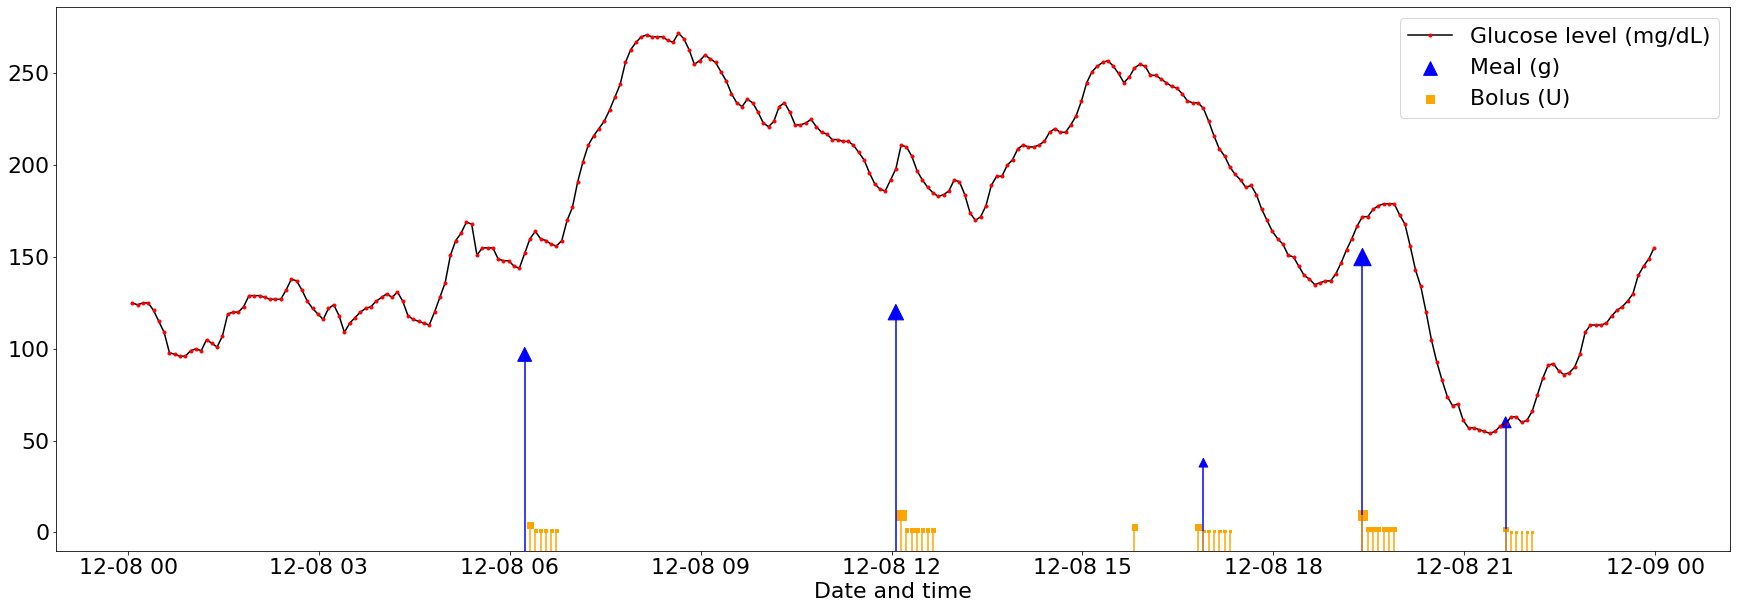

In [51]:
import matplotlib.pyplot as plt
# save statistics

plt.rcParams['figure.figsize'] = (30,10)

pid = 570

st = pd.to_datetime('08122021000000', format='%d%m%Y%H%M%S')

ed = pd.to_datetime('08122021235959', format='%d%m%Y%H%M%S')

glucose = sub_train_pid2data[pid].loc[st:ed, 'glucose_level']

plt.plot(glucose.index, glucose.to_numpy(), label='Glucose level (mg/dL)', marker='o', markersize=3, markerfacecolor='r', markeredgecolor='r', color='black')

meal = sub_train_pid2data[pid].loc[st:ed, 'meal']
meal = meal[pd.notna(meal)]
plt.scatter(meal.index, meal.to_numpy(), marker='^', s=meal.to_numpy()*2, label='Meal (g)', color='b')
plt.vlines(meal.index, -10, meal.to_numpy(), colors='b')
plt.ylim(-10)
plt.legend( fontsize=22)

bolus = sub_train_pid2data[pid].loc[st:ed, 'bolus']
bolus = bolus[pd.notna(bolus)]
plt.scatter(bolus.index, bolus.to_numpy(), marker='s', s=bolus.to_numpy()*10, label='Bolus (U)', color='orange')
plt.vlines(bolus.index, -10, bolus.to_numpy(), colors='orange')
plt.ylim(-10)
plt.legend( fontsize=22)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Date and time', fontsize=22)

plt.savefig('./results/show_glucose.pdf')

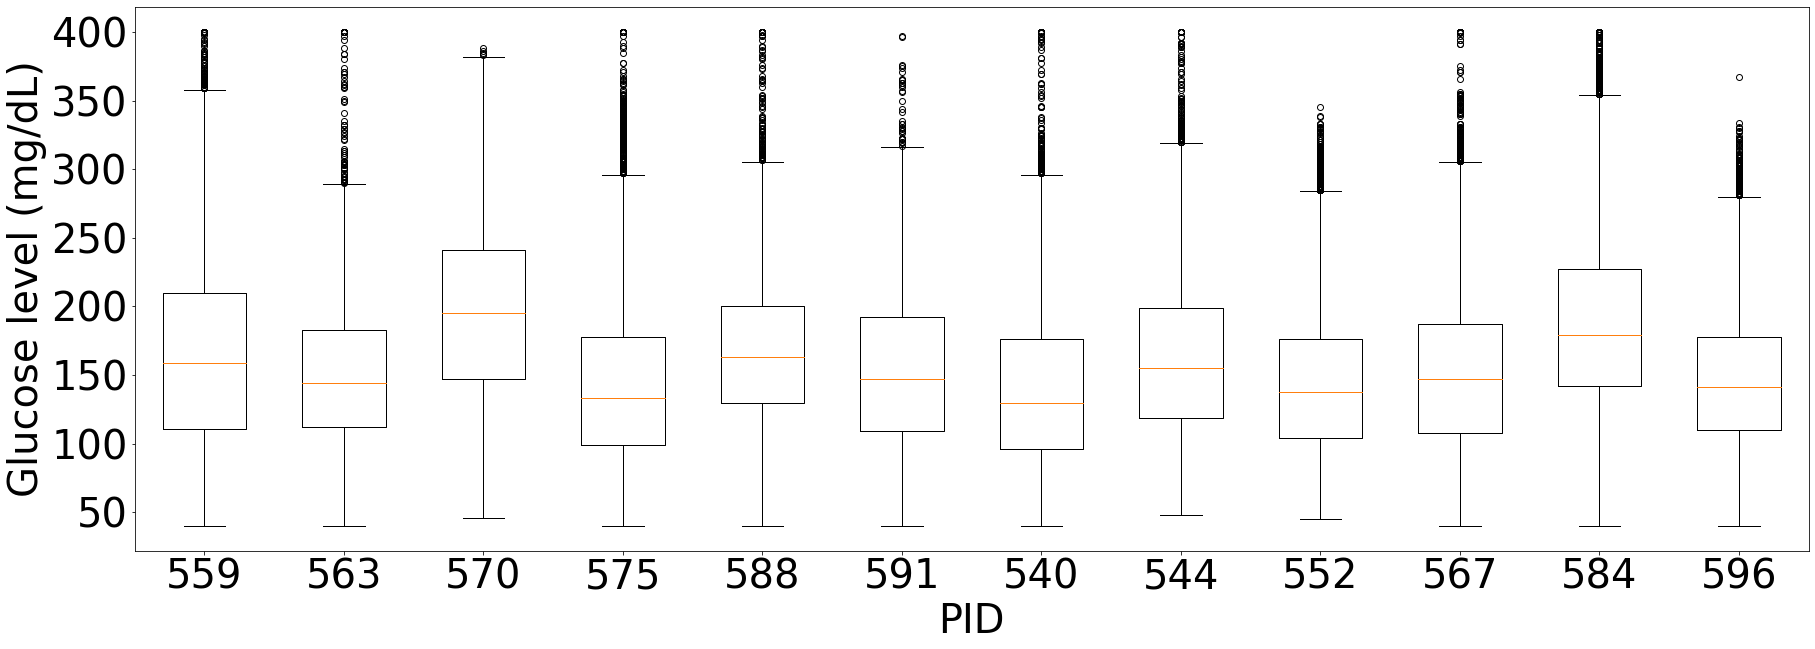

In [52]:
# save statistics
plt.rcParams['figure.figsize'] = (30, 10)
for i,pid in enumerate(sub_test_pid2data):

    attri = 'glucose_level'
    if attri in sub_test_pid2data[pid].columns:
        values = pd.concat([sub_train_pid2data[pid].loc[:, attri], sub_test_pid2data[pid].loc[:, attri]], axis=0)
    else:
        values = sub_train_pid2data[pid].loc[:, attri]
    values = values[pd.notna(values)]
    plt.boxplot(values, positions=[i], widths = 0.6)

plt.xticks(fontsize=40, labels=list(sub_test_pid2data.keys()), ticks=np.arange(len(sub_test_pid2data)))

plt.yticks(fontsize=40)

plt.xlabel('PID', fontsize=40)

plt.ylabel('Glucose level (mg/dL)', fontsize=40)
plt.savefig('./results/glucose_level.pdf')

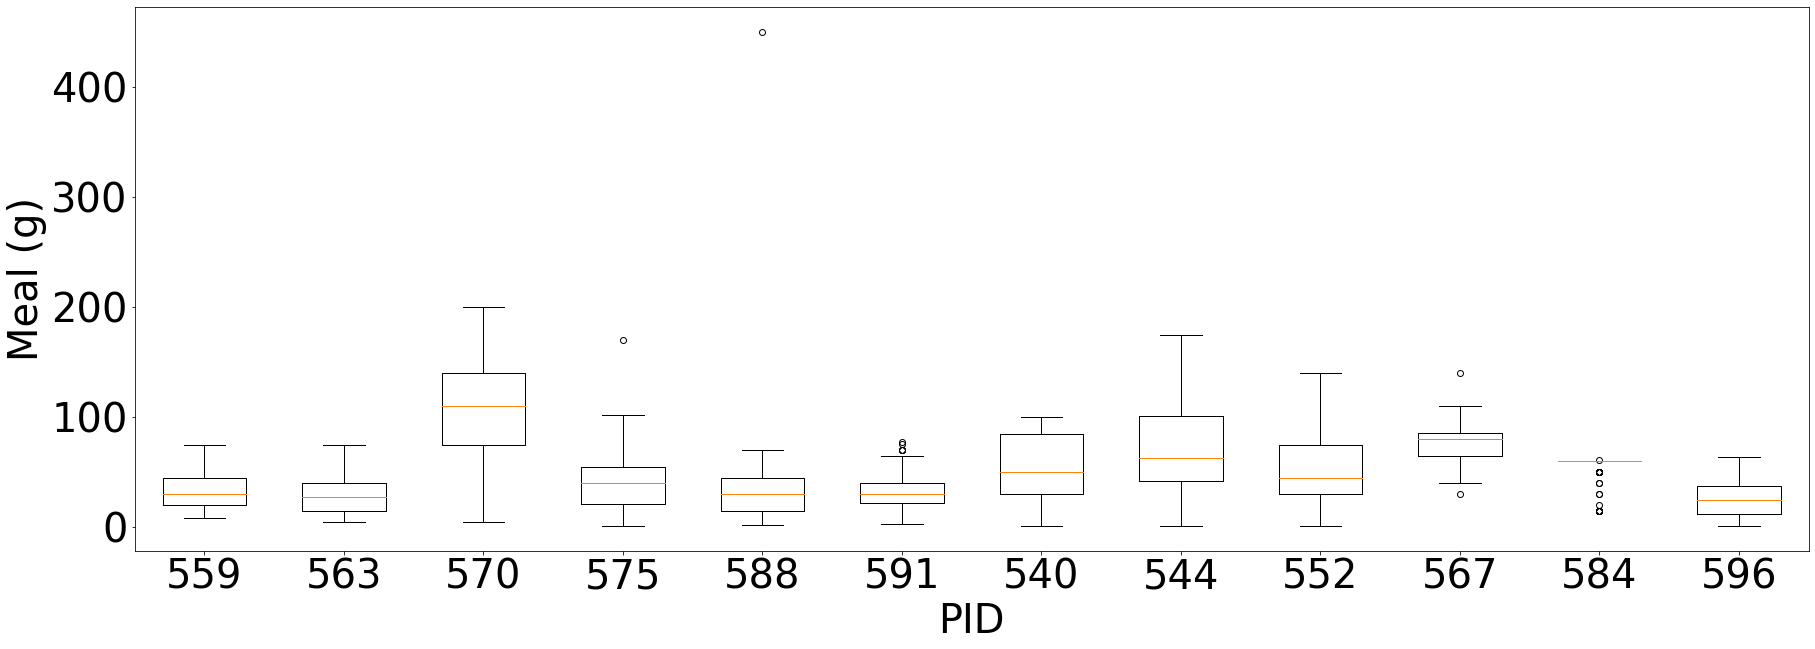

In [53]:
# save statistics
plt.rcParams['figure.figsize'] = (30, 10)
for i,pid in enumerate(sub_test_pid2data):

    attri = 'meal'
    if attri in sub_test_pid2data[pid].columns:
        values = pd.concat([sub_train_pid2data[pid].loc[:, attri], sub_test_pid2data[pid].loc[:, attri]], axis=0)
    else:
        values = sub_train_pid2data[pid].loc[:, attri]
    values = values[pd.notna(values)]
    plt.boxplot(values, positions=[i], widths = 0.6)

plt.xticks(fontsize=40, labels=list(sub_test_pid2data.keys()), ticks=np.arange(len(sub_test_pid2data)))

plt.yticks(fontsize=40)

plt.xlabel('PID', fontsize=40)

plt.ylabel('Meal (g)', fontsize=40)
plt.savefig('./results/meal.pdf')

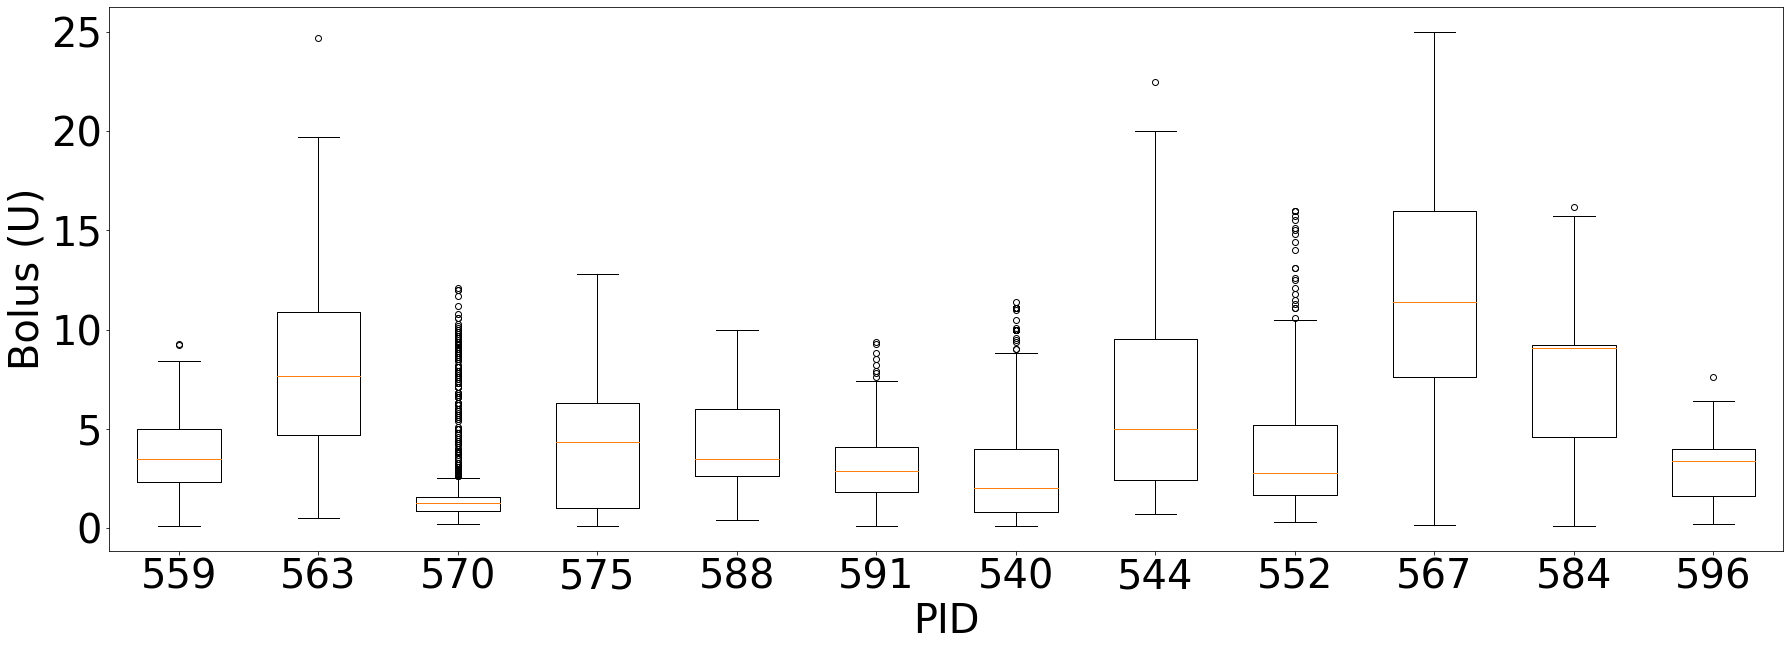

In [54]:
# save statistics
plt.rcParams['figure.figsize'] = (30, 10)
for i,pid in enumerate(sub_test_pid2data):

    attri = 'bolus'
    if attri in sub_test_pid2data[pid].columns:
        values = pd.concat([sub_train_pid2data[pid].loc[:, attri], sub_test_pid2data[pid].loc[:, attri]], axis=0)
    else:
        values = sub_train_pid2data[pid].loc[:, attri]
    values = values[pd.notna(values)]
    plt.boxplot(values, positions=[i], widths = 0.6)

plt.xticks(fontsize=40, labels=list(sub_test_pid2data.keys()), ticks=np.arange(len(sub_test_pid2data)))

plt.yticks(fontsize=40)

plt.xlabel('PID', fontsize=40)

plt.ylabel('Bolus (U)', fontsize=40)
plt.savefig('./results/bolus.pdf')

In [55]:
def add_time_attributes(pid2data):
    for pid in pid2data:
        data = pid2data[pid]

        data['date_temp'] = data.index

        data['day_of_week'] = data['date_temp'].dt.dayofweek
        data['day_of_week'] = data['day_of_week'].astype(float)

        data['week'] = data['date_temp'].dt.isocalendar().week
        data['week'] = data['week'].astype(float)

        data['year'] = data['date_temp'].dt.year
        data['year'] = data['year'].astype(float)


        data['hour'] = data['date_temp'].dt.hour
        data['hour'] = data['hour'].astype(float)

        data['minute'] = data['date_temp'].dt.minute
        data['minute'] = data['minute'].astype(float)

        # there is an error previously 360 -> 3600
        data['timestamp'] = data['date_temp'].dt.hour * 3600 +\
                                data['date_temp'].dt.minute * 60 +\
                                data['date_temp'].dt.second
        data['timestamp'] = data['timestamp'].astype(float)

        # new ————————————————————————
        seconds_in_day = 24*60*60

        data['sin_time'] = np.sin(2 * np.pi * data.timestamp / seconds_in_day)
        data['cos_time'] = np.cos(2 * np.pi * data.timestamp / seconds_in_day)
        data['sin_time'].astype(np.float64)
        data['cos_time'].astype(np.float64)
        # end ______________________


        pid2data[pid] = data.drop(['date_temp'], axis=1)
    
    return pid2data

In [56]:
sub_train_pid2data = add_time_attributes(sub_train_pid2data)
sub_test_pid2data = add_time_attributes(sub_test_pid2data)

In [57]:
# add discrete y

def discrete(y):
    if y < 70:
        return 0
    elif 70<= y <=180:
        return 1
    elif y > 180:
        return 2
    else:
        return np.nan


def add_discrete_y(pid2data):
    for pid in pid2data:
        data = pid2data[pid]
        data['discrete_y'] = data['glucose_level']

        data['discrete_y'] = data['discrete_y'].apply(discrete)
        
    return pid2data

In [58]:
sub_train_pid2data = add_discrete_y(sub_train_pid2data)
sub_test_pid2data = add_discrete_y(sub_test_pid2data)

In [59]:
# save statistics
MAE_list = []
for pid in sub_train_pid2data:
    df = sub_train_pid2data[pid][['glucose_level', 'finger_stick']].copy()
    df = df[pd.notna(df['finger_stick'])]
    temp = abs(df['finger_stick'] - df['glucose_level']).mean()
    MAE_list.append(temp)
    print(pid,'MAE glucose_level finger_stick', temp)


559 MAE glucose_level finger_stick 38.29661016949152
563 MAE glucose_level finger_stick 18.21656050955414
570 MAE glucose_level finger_stick 12.06046511627907
575 MAE glucose_level finger_stick 16.488636363636363
588 MAE glucose_level finger_stick 20.158490566037734
591 MAE glucose_level finger_stick 22.125
540 MAE glucose_level finger_stick 12.71866295264624
544 MAE glucose_level finger_stick 14.686746987951807
552 MAE glucose_level finger_stick 14.13076923076923
567 MAE glucose_level finger_stick 9.25
584 MAE glucose_level finger_stick 47.03030303030303
596 MAE glucose_level finger_stick 25.87313432835821


In [60]:
np.mean(MAE_list), np.std(MAE_list)

(20.919614937918947, 10.81701907049203)

In [61]:
# save statistics
temp_pid_attri_hour_range2mean_std_count = {}

temp_attribute = ['glucose_level', 'meal', 'bolus', 'finger_stick', 'sleep', 'exercise']
for pid in sub_train_pid2data:
    for attri in temp_attribute:
        try:
            if attri in sub_test_pid2data[pid].columns:
                values = pd.concat([sub_train_pid2data[pid][[attri, 'hour']], sub_test_pid2data[pid][[attri, 'hour']]], axis=0)
            else:
                values = sub_train_pid2data[pid][[attri, 'hour']]
        except:
            continue
        hour_range = '22-6'
        temp1 = values[(22<=values['hour']) & (values['hour']<24)]
        temp2 = values[(0<=values['hour']) & (values['hour']<6)]
        temp = pd.concat([temp1, temp2], axis=0)
        temp_pid_attri_hour_range2mean_std_count[(pid, attri, hour_range)] = (temp[attri].mean(), temp[attri].std(), pd.notna(temp[attri]).sum())

        hour_range = '6-16'
        temp = values[(6<=values['hour']) & (values['hour']<16)]
        temp_pid_attri_hour_range2mean_std_count[(pid, attri, hour_range)] = (temp[attri].mean(), temp[attri].std(), pd.notna(temp[attri]).sum())

        hour_range = '16-22'
        temp = values[(16<=values['hour']) & (values['hour']<22)]
        temp_pid_attri_hour_range2mean_std_count[(pid, attri, hour_range)] = (temp[attri].mean(), temp[attri].std(), pd.notna(temp[attri]).sum())

# import xlwt
# book = xlwt.Workbook(encoding='utf-8', style_compression=0)


# Hours = ['22-6', '6-16', '16-22']
# for h in Hours:
#     sheet = book.add_sheet(h, cell_overwrite_ok=True)
#     sheet.write(0, 0, 'PID')
#     for i, pid in enumerate(sub_train_pid2data):
#         sheet.write(i+1, 0, pid)
#         for j, attri in enumerate(temp_attribute):
#             sheet.write(0, j+1, attri)
#         for j, attri in enumerate(temp_attribute):
#             if (pid, attri, h) in temp_pid_attri_hour_range2mean_std:
#                 mean = temp_pid_attri_hour_range2mean_std[(pid, attri, h)][0]
#                 std = temp_pid_attri_hour_range2mean_std[(pid, attri, h)][1]
#                 sheet.write(i+1, j+1, f'{mean:.2f}'+r'$\pm$'+f'{std:.2f}')
#             else:
#                 sheet.write(i+1, j+1, 'None')

# if not os.path.exists('./results'):
#     os.makedirs('./results')
# book.save('./results/statistics3.xls')    

# save statistics

import xlwt
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('statistics4', cell_overwrite_ok=True)
sheet2 = book.add_sheet('statistics4_count', cell_overwrite_ok=True)

Hours = ['22-6', '6-16', '16-22']
    
sheet.write(0, 0, 'PID')
sheet2.write(0, 0, 'PID')
for i, pid in enumerate(sub_train_pid2data):
    sheet.write(i+1, 0, pid)
    sheet2.write(i+1, 0, pid)
    counter = 0
    for j, attri in enumerate(temp_attribute):
        for h in Hours:
            sheet.write(0, counter+1, attri + f' ({h})')
            sheet2.write(0, counter+1, attri + f' ({h})')
            if (pid, attri, h) in temp_pid_attri_hour_range2mean_std_count:
                mean = temp_pid_attri_hour_range2mean_std_count[(pid, attri, h)][0]
                std = temp_pid_attri_hour_range2mean_std_count[(pid, attri, h)][1]
                count = temp_pid_attri_hour_range2mean_std_count[(pid, attri, h)][2]
                if pd.notna(mean):
                    sheet.write(i+1, counter+1, f'{mean:.2f}'+r'$\pm$'+f'{std:.2f}')
                    sheet2.write(i+1, counter+1, str(count))
                else:
                    sheet.write(i+1, counter+1, 'None')
                    sheet2.write(i+1, counter+1, 'None')
            else:
                sheet.write(i+1, counter+1, 'None')
                sheet2.write(i+1, counter+1, 'None')
            counter += 1

if not os.path.exists('./results'):
    os.makedirs('./results')
book.save('./results/statistics4.xls')    

In [62]:
# save statistics
temp_pid_attri_hour_range2mean_std_count = {}

temp_attribute = ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'acceleration', 'basis_air_temperature','basis_steps',
    'basis_heart_rate'  
]

import xlwt
book = xlwt.Workbook(encoding='utf-8', style_compression=0)
sheet = book.add_sheet('statistics5', cell_overwrite_ok=True)
sheet.write(0, 0, 'PID')


temp_attri2idx = {}
for idx, attri in enumerate(temp_attribute):
    temp_attri2idx[attri] = idx
    sheet.write(0, 1 + 4 * idx, attri+' (low)')
    sheet.write(0, 1 + 4 * idx + 1, attri+' (normal)')
    sheet.write(0, 1 + 4 * idx + 2, attri+' (high)')
    sheet.write(0, 1 + 4 * idx + 3, attri+' (all)')



for i, pid in enumerate(sub_train_pid2data):
    sheet.write(i + 1, 0, pid)
    values = pd.concat([sub_train_pid2data[pid], sub_test_pid2data[pid]], axis=0)

    exist_attri = []
    for attri in temp_attribute:
        if attri in values.columns:
            exist_attri.append(attri)
    print(pid, exist_attri)
    low = values[values['glucose_level']<70][exist_attri]
    normal = values[(70<=values['glucose_level']) & (values['glucose_level']<=180)][exist_attri]
    high = values[180<values['glucose_level']][exist_attri]
    all_values = values[pd.notna(values['glucose_level'])][exist_attri]
    
    for attri in exist_attri:
        idx = temp_attri2idx[attri]
        sheet.write(i + 1, 1 + 4 * idx, f'{low[attri].mean():.2f}'+r'$\pm$'+f'{low[attri].std():.2f}')
        sheet.write(i + 1, 1 + 4 * idx + 1, f'{normal[attri].mean():.2f}'+r'$\pm$'+f'{normal[attri].std():.2f}')
        sheet.write(i + 1, 1 + 4 * idx + 2, f'{high[attri].mean():.2f}'+r'$\pm$'+f'{high[attri].std():.2f}')
        sheet.write(i + 1, 1 + 4 * idx + 3, f'{all_values[attri].mean():.2f}'+r'$\pm$'+f'{all_values[attri].std():.2f}')


if not os.path.exists('./results'):
    os.makedirs('./results')
book.save('./results/statistics5.xls')   



559 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
563 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
570 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
575 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
588 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
591 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate']
540 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'acceleration']
544 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'acceleration']
552 ['glucose_level', 'basis_gsr', 'basis_skin_temperature', 'acceleration']
567 ['glucose_level', 'basis_gsr', 'basis_s

In [63]:
new_sub_valid_pid2data = {}

new_sub_train_pid2data = {}

for pid in sub_train_pid2data:
    mid = int(len(sub_train_pid2data[pid]) * 0.8)
    new_sub_train_pid2data[pid] = copy.deepcopy(sub_train_pid2data[pid].iloc[:mid])
    new_sub_valid_pid2data[pid] = copy.deepcopy(sub_train_pid2data[pid].iloc[mid:])
    print(pid, len(new_sub_train_pid2data[pid]), len(new_sub_valid_pid2data[pid]))
sub_train_pid2data = new_sub_train_pid2data
sub_valid_pid2data = new_sub_valid_pid2data


559 9661 2416
563 10475 2619
570 9286 2322
575 10478 2620
588 10482 2621
591 10200 2551
540 10484 2622
544 10136 2534
552 8873 2219
567 10825 2707
584 10596 2649
596 10900 2726


In [64]:
tmp_all_df = pd.concat(sub_train_pid2data.values())
tmp_all_df[['glucose_level', 'finger_stick','basal', 'meal', 'bolus', 'sleep', 'work', 'exercise', 'basis_gsr',
    'basis_skin_temperature', 'acceleration', 'basis_sleep', 'basis_air_temperature', 'basis_steps', 'basis_heart_rate','timestamp']].corr(method='pearson')['glucose_level'].sort_values()

work                     -0.076063
exercise                 -0.060323
basis_heart_rate         -0.038396
basis_skin_temperature   -0.032914
basis_steps              -0.017112
basis_gsr                -0.005491
basis_air_temperature    -0.004664
acceleration              0.004206
timestamp                 0.046545
basis_sleep               0.060231
sleep                     0.103794
bolus                     0.137113
meal                      0.143917
basal                     0.458402
finger_stick              0.899117
glucose_level             1.000000
Name: glucose_level, dtype: float64

In [65]:
sub_train_pid2data[pid].columns

Index(['glucose_level', 'finger_stick', 'basal_', 'temp_basal', 'meal_cat',
       'meal', 'basis_gsr', 'basis_skin_temperature', 'acceleration',
       'glucose_level_indicate', 'basal', 'bolus', 'bolus_cat', 'sleep',
       'basis_sleep', 'exercise', 'stressors', 'hypo_event', 'illness',
       'day_of_week', 'week', 'year', 'hour', 'minute', 'timestamp',
       'sin_time', 'cos_time', 'discrete_y'],
      dtype='object')

In [66]:
pid_attri2mean_std = {}
attris_should_ignore = ['glucose_level_indicate', 'day_of_week', 'hour', 'minute', 'sin_time', 'cos_time', 'discrete_y']
for pid in sub_train_pid2data:
    for attri in sub_train_pid2data[pid].columns:
        if attri in attris_should_ignore:
            continue
        if sub_train_pid2data[pid][attri].dtypes == float:
            mean = sub_train_pid2data[pid][attri].mean()
            std = sub_train_pid2data[pid][attri].std()
            if std is np.NaN or std is pd.NaT or std == 0:
                std = 1e-6
            pid_attri2mean_std[(pid, attri)] = (mean, std)
            print(pid, attri, pid_attri2mean_std[(pid, attri)])
if not os.path.exists(save_path):
    os.makedirs(save_path)
np.save(os.path.join(save_path, 'pid_attri2mean_std.npy'), pid_attri2mean_std)

559 glucose_level (166.2308500700607, 69.49415888102592)
559 finger_stick (191.17424242424244, 109.17186508151221)
559 basal_ (0.9180327868852468, 0.2117289681194554)
559 temp_basal (0.0, 1e-06)
559 meal_cat (2.3658536585365852, 1.2820852167460628)
559 meal (36.422764227642276, 16.94639965151519)
559 basis_heart_rate (73.98745892661556, 15.371399146307194)
559 basis_gsr (0.3048659347418343, 1.612270182891089)
559 basis_skin_temperature (87.72462967033027, 3.4704564845292007)
559 basis_air_temperature (84.39047472527494, 4.380748861038662)
559 basis_steps (2.64084892243737, 11.531867211337092)
559 basal (0.7671232876712336, 0.39239487307999016)
559 bolus (3.808686440677965, 2.0005057510076223)
559 bolus_cat (2.0, 1e-06)
559 sleep (2.2811906269791007, 0.6119656618242353)
559 basis_sleep (93.19657072872015, 3.0195788674333306)
559 work (4.211277658815132, 0.8483015859396118)
559 exercise (4.10828025477707, 1.4168383810007605)
559 stressors (1.0, nan)
559 hypo_event (1.0, 1e-06)
559 illnes

552 hypo_event (1.0, 1e-06)
552 illness (1.0, nan)
552 week (18.049588639693454, 1.3140781121289096)
552 year (2025.0, 1e-06)
552 timestamp (43164.71824636538, 25001.103135083897)
567 glucose_level (151.13671785468713, 60.09403890894422)
567 finger_stick (180.8920634920635, 68.79782830038648)
567 basal_ (1.2118421052631574, 0.26800662318283275)
567 temp_basal (0.0, 1e-06)
567 meal_cat (2.2758620689655173, 1.250615611955566)
567 meal (74.96551724137932, 21.40340887172063)
567 basis_gsr (0.7850424223354391, 2.1519593340467296)
567 basis_skin_temperature (89.11332058231585, 3.6984002961330305)
567 acceleration (0.9949964973535447, 0.057431574161879995)
567 basal (0.9305743243243239, 0.5644049071369067)
567 bolus (11.711270491803273, 5.743092650656333)
567 bolus_cat (2.0, 1e-06)
567 sleep (2.0032537960954446, 0.7241680528319061)
567 basis_sleep (90.0, 1e-06)
567 illness (1.0, nan)
567 week (12.072886836027713, 19.60790235690936)
567 year (2026.8935796766743, 0.3083890784082396)
567 timesta

In [67]:
attris_indicate_set = (set(sub_train_pid2data[559].columns) | set(sub_train_pid2data[584].columns)) - set(['bolus_cat','day_of_week','glucose_level_indicate', 'hour', 'meal_cat', 'minute','timestamp', 'glucose_level', 'sin_time', 'cos_time'])
attris_indicate_set

{'acceleration',
 'basal',
 'basal_',
 'basis_air_temperature',
 'basis_gsr',
 'basis_heart_rate',
 'basis_skin_temperature',
 'basis_sleep',
 'basis_steps',
 'bolus',
 'discrete_y',
 'exercise',
 'finger_stick',
 'hypo_event',
 'illness',
 'meal',
 'sleep',
 'stressors',
 'temp_basal',
 'week',
 'work',
 'year'}

In [68]:
def add_indicate_for_nan(pid2data):
    new_pid2data = {}
    for pid in pid2data:
        data = copy.deepcopy(pid2data[pid])

        for attri in attris_indicate_set:
            if not attri in data:
                continue
            data[attri + '_indicate'] = 1
            data.loc[pd.notna(data[attri]), attri + '_indicate'] = 0
            if sum(data[attri + '_indicate'][pd.notna(data[attri + '_indicate'])]) != len(data[attri]) - sum(pd.notna(data[attri])):
                print('error')
        new_pid2data[pid] = data
    return new_pid2data

In [69]:
sub_train_pid2data = add_indicate_for_nan(sub_train_pid2data)
sub_valid_pid2data = add_indicate_for_nan(sub_valid_pid2data)
sub_test_pid2data = add_indicate_for_nan(sub_test_pid2data)

In [70]:
def norm_data(pid2data, pid_attri2mean_std, not_norm_attris):

    new_pid2data = {}
    for pid in pid2data:

        new_pid2data[pid] = copy.deepcopy(pid2data[pid]) 

        for attri in pid2data[pid]:
            if attri in not_norm_attris or 'indicate' in attri:
                continue
            
            if (pid, attri) not in pid_attri2mean_std:
                new_pid2data[pid] = new_pid2data[pid].drop([attri], axis=1)
                print(pid, attri)
                continue

            mean, std = pid_attri2mean_std[(pid, attri)]

            if std <= 1e-6:
                new_pid2data[pid][attri] = new_pid2data[pid][attri] / mean
            else:
                new_pid2data[pid][attri] = (new_pid2data[pid][attri] - mean) / std

            

    return new_pid2data

In [71]:
not_norm_attris = ['day_of_week', 'hour', 'minute', 'sin_time', 'cos_time', 'discrete_y']

norm_sub_train_pid2data = norm_data(sub_train_pid2data, pid_attri2mean_std, not_norm_attris)

norm_sub_valid_pid2data = norm_data(sub_valid_pid2data, pid_attri2mean_std, not_norm_attris)

norm_sub_test_pid2data = norm_data(sub_test_pid2data, pid_attri2mean_std, not_norm_attris)

544 exercise
584 hypo_event


In [72]:
norm_sub_train_pid2data[596].describe()

,glucose_level,finger_stick,basal_,temp_basal,meal_cat,meal,basis_gsr,basis_skin_temperature,acceleration,glucose_level_indicate,...,year_indicate,basal__indicate,exercise_indicate,sleep_indicate,basis_skin_temperature_indicate,basal_indicate,acceleration_indicate,discrete_y_indicate,bolus_indicate,finger_stick_indicate
count,8.749000e+03,1.320000e+02,6.000000e+00,6.000000e+00,1.990000e+02,1.990000e+02,5.440000e+03,5.440000e+03,5.440000e+03,10900.000000,...,10900.0,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000
mean,4.418558e-16,-2.338197e-16,-5.921189e-16,3.700743e-17,-3.905307e-17,-2.901085e-17,2.457440e-16,-5.905536e-14,-5.464297e-15,0.197339,...,0.0,0.999450,0.927523,0.750550,0.500917,0.998899,0.500917,0.197339,0.986789,0.987890
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.398009,...,0.0,0.023456,0.259288,0.432714,0.500022,0.033163,0.500022,0.398009,0.114183,0.109383
min,-2.146751e+00,-2.188476e+00,-8.951436e-01,-8.475794e-01,-1.797991e+00,-1.692147e+00,-1.887427e-01,-5.221854e+00,-3.724818e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.564540e-01,-7.552954e-01,-7.608721e-01,-8.475794e-01,-9.792261e-01,-9.679811e-01,-1.836755e-01,-5.090317e-01,-3.722873e-01,0.000000,...,0.0,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
50%,-1.721263e-01,-5.724000e-03,-3.580574e-01,-3.390318e-01,-1.604614e-01,-2.656490e-02,-1.790179e-01,9.489004e-02,1.035108e-01,0.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,6.338428e-01,6.179194e-01,8.503864e-01,9.323373e-01,6.583033e-01,8.424347e-01,-1.592087e-01,6.541624e-01,6.279350e-01,0.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,4.442047e+00,3.016548e+00,1.253201e+00,1.186611e+00,1.477068e+00,2.870100e+00,2.356524e+01,2.589483e+00,4.908671e+00,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [73]:
def count_len_of_continuous_series(pid2data):
    len_num = {}
    num_of_breaks = 0
    total_samples = 0
    for pid in pid2data:
        pre_st = pid2data[pid].index[0]
        total_samples += len(pid2data[pid])
        for st, ed in zip(pid2data[pid].index[:-1], pid2data[pid].index[1:]):
            num_5_mins = (ed - st).total_seconds() / 60 // 5
            if num_5_mins >= 12:
                num_of_breaks += 1
                k = len(pid2data[pid].loc[pre_st:st])
                if k not in len_num:
                    len_num[k] = 0
                len_num[k] += 1
                pre_st = ed
    print(len_num)
    print(num_of_breaks, num_of_breaks/total_samples)
    print(num_of_breaks * 23, num_of_breaks*23/total_samples)

In [74]:
count_len_of_continuous_series(norm_sub_train_pid2data)

{}
0 0.0
0 0.0


In [75]:
for pid in norm_sub_train_pid2data:
    norm_sub_train_pid2data[pid] = norm_sub_train_pid2data[pid].fillna(0)
for pid in norm_sub_valid_pid2data:
    norm_sub_valid_pid2data[pid] = norm_sub_valid_pid2data[pid].fillna(0)
for pid in norm_sub_test_pid2data:
    norm_sub_test_pid2data[pid] = norm_sub_test_pid2data[pid].fillna(0)

In [76]:
attri_list_wo_glucose = [
    'meal', 'meal_cat',
    'bolus', 'bolus_cat', 'basal', 'basal_', 'temp_basal', 'finger_stick',
    'basis_skin_temperature', 'basis_gsr', 'basis_sleep', 'acceleration',
    'exercise', 'sleep', 'work', 'basis_steps', 'basis_heart_rate', 'basis_air_temperature', 'stressors', 'hypo_event', 'illness',
    'day_of_week', 'hour', 'minute', 'timestamp', 'sin_time', 'cos_time',
    'meal_indicate', 
    'bolus_indicate', 'basal_indicate', 'finger_stick_indicate',
    'basis_skin_temperature_indicate', 'basis_gsr_indicate', 'basis_sleep_indicate', 'acceleration_indicate',
    'exercise_indicate', 'sleep_indicate', 'work_indicate', 'basis_steps_indicate', 'basis_heart_rate_indicate', 'basis_air_temperature_indicate',
    'stressors_indicate', 'hypo_event_indicate', 'illness_indicate',
]

temp = []

for idx, attri in enumerate(attri_list_wo_glucose):
    temp.append({'attri':attri, 'idx':idx}, )
attri2idx = pd.DataFrame(temp).set_index('attri')
idx2attri = pd.DataFrame(temp).set_index('idx')
print(attri2idx)
print(idx2attri)

attri2idx.to_pickle(os.path.join(save_path,'attri2idx.pkl'))
idx2attri.to_pickle(os.path.join(save_path,'idx2attri.pkl'))


                                 idx
attri                               
meal                               0
meal_cat                           1
bolus                              2
bolus_cat                          3
basal                              4
basal_                             5
temp_basal                         6
finger_stick                       7
basis_skin_temperature             8
basis_gsr                          9
basis_sleep                       10
acceleration                      11
exercise                          12
sleep                             13
work                              14
basis_steps                       15
basis_heart_rate                  16
basis_air_temperature             17
stressors                         18
hypo_event                        19
illness                           20
day_of_week                       21
hour                              22
minute                            23
timestamp                         24
s

In [77]:
# generate training data


def gen_train(n_prev, pred_window, valid_points = 24): 
    train_pid2data_npy = {}
    for pid in norm_sub_train_pid2data:
        data = norm_sub_train_pid2data[pid]
        contained_attri = [attri for attri in data.columns if attri in attri2idx.index]

        y_list = []
        y_dis_list = []
        target_sin_time_list = []
        target_cos_time_list = []
        target_total_seconds_list = []
        glucose_level_X_list =[]
        attri_X_list = []

        seq_st_ed_list = []
        
        seq_st, seq_ed = None, None

        for idx in range(len(data) - n_prev - pred_window + 1):
            glucose_level_y = data.iloc[idx + n_prev + pred_window - 1]['glucose_level']
            glucose_level_y_indicate = data.iloc[idx + n_prev + pred_window - 1]['glucose_level_indicate']
            if abs(glucose_level_y_indicate - 1) < 1e-6:
                continue

            #TODO Resonable
            num_valids = int(valid_points - sum(data.iloc[idx + n_prev - valid_points : idx + n_prev]['glucose_level_indicate']))
            if num_valids == 0:
                if seq_st is not None and seq_ed - seq_st >= 2:
                    seq_st_ed_list.append([seq_st, seq_ed])
                seq_st, seq_ed = None, None
                continue
            # end

            
            y_list.append(glucose_level_y)
            y_dis_list.append(data.iloc[idx + n_prev + pred_window - 1]['discrete_y'])
            target_cos_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['cos_time'])
            target_sin_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['sin_time'])
            target_total_seconds_list.append(data.iloc[idx + n_prev + pred_window - 1]['timestamp'])

            glucose_level_X = np.array(data.iloc[idx: idx + n_prev]['glucose_level'].to_numpy(), dtype=np.float32)


            attri_X = np.zeros(shape = (n_prev, len(attri2idx.index)), dtype=np.float32)
            
            attri_X[:, attri2idx.loc[contained_attri, 'idx']] = data.iloc[idx: idx + n_prev][contained_attri].fillna(0).to_numpy()
           

            glucose_level_X_list.append(np.expand_dims(glucose_level_X, axis=0))

            attri_X_list.append(np.expand_dims(attri_X, axis=0))

            if seq_st is None:
                seq_st = len(y_list) - 1
            else:
                seq_ed = len(y_list) - 1
        
        if seq_st is not None and seq_ed - seq_st >= 2:
            seq_st_ed_list.append([seq_st, seq_ed])

        train_pid2data_npy[pid] = {}
        train_pid2data_npy[pid]['glucose_level_X'] = np.concatenate(glucose_level_X_list, axis=0)

        train_pid2data_npy[pid]['attri_X'] = np.concatenate(attri_X_list, axis=0)
        train_pid2data_npy[pid]['y'] = np.array(y_list, dtype=np.float32)
        train_pid2data_npy[pid]['y_dis'] = np.array(y_dis_list, dtype=np.int32)
        train_pid2data_npy[pid]['target_cos_time'] = np.array(target_cos_time_list, dtype=np.float32)
        train_pid2data_npy[pid]['target_sin_time'] = np.array(target_sin_time_list, dtype=np.float32)
        train_pid2data_npy[pid]['target_timestamp'] = np.array(target_total_seconds_list, dtype=np.float32)
        train_pid2data_npy[pid]['mean'] = pid_attri2mean_std[(pid, 'glucose_level')][0]
        train_pid2data_npy[pid]['std'] = pid_attri2mean_std[(pid, 'glucose_level')][1]
        
        train_pid2data_npy[pid]['seq_st_ed_list'] = np.array(seq_st_ed_list, dtype=np.int32)

    np.save(os.path.join(save_path, f'train_pid2data_npy_{n_prev}_{pred_window}.npy'), train_pid2data_npy)



In [78]:
n_prev = 24
pred_window = 6
gen_train(n_prev, pred_window, 12)

In [79]:
n_prev = 24
pred_window = 12
gen_train(n_prev, pred_window, 12)

In [80]:
def gen_val(n_prev, pred_window, valid_points=24):
    
    # generate validation data
    valid_pid2data_npy = {}

    for pid in norm_sub_valid_pid2data:
        data = pd.concat([norm_sub_train_pid2data[pid].iloc[-(n_prev + pred_window - 1):], norm_sub_valid_pid2data[pid]], axis=0)
        data['glucose_level_zero'] = data['glucose_level']
        contained_attri = [attri for attri in data.columns if attri in attri2idx.index]

        y_list = []
        y_dis_list = []
        target_sin_time_list = []
        target_cos_time_list = []
        target_total_seconds_list = []
        
        glucose_level_X_list =[]

        attri_X_list = []

        seq_st_ed_list = []
        
        seq_st, seq_ed = None, None

        for idx in range(len(data) - n_prev - pred_window + 1):
            glucose_level_y = data.iloc[idx + n_prev + pred_window - 1]['glucose_level']
            glucose_level_y_indicate = data.iloc[idx + n_prev + pred_window - 1]['glucose_level_indicate']
            if abs(glucose_level_y_indicate - 1) < 1e-6:
                continue

            #TODO Resonable
            
            num_valids = int(valid_points - sum(data.iloc[idx + n_prev - valid_points : idx + n_prev]['glucose_level_indicate']))
            if num_valids == 0:
                if seq_st is not None and seq_ed - seq_st >= 2:
                    seq_st_ed_list.append([seq_st, seq_ed])
                seq_st, seq_ed = None, None
                continue

            y_list.append(glucose_level_y)
            y_dis_list.append(data.iloc[idx + n_prev + pred_window - 1]['discrete_y'])
            target_cos_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['cos_time'])
            target_sin_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['sin_time'])
            target_total_seconds_list.append(data.iloc[idx + n_prev + pred_window - 1]['timestamp'])

            
            glucose_level_X = np.array(data.iloc[idx: idx + n_prev]['glucose_level'].to_numpy(), dtype=np.float32)

            attri_X = np.zeros(shape = (n_prev, len(attri2idx.index)), dtype=np.float32)
            
            attri_X[:, attri2idx.loc[contained_attri, 'idx']] = data.iloc[idx: idx + n_prev][contained_attri].fillna(0.0).to_numpy()

            glucose_level_X_list.append(np.expand_dims(glucose_level_X, axis=0))
            attri_X_list.append(np.expand_dims(attri_X, axis=0))
            if seq_st is None:
                seq_st = len(y_list) - 1
            else:
                seq_ed = len(y_list) - 1

        if seq_st is not None and seq_ed - seq_st >= 2:
            seq_st_ed_list.append([seq_st, seq_ed])

        valid_pid2data_npy[pid] = {}
        valid_pid2data_npy[pid]['glucose_level_X'] = np.concatenate(glucose_level_X_list, axis=0)
        valid_pid2data_npy[pid]['attri_X'] = np.concatenate(attri_X_list, axis=0)
        valid_pid2data_npy[pid]['y'] = np.array(y_list, dtype=np.float32)
        valid_pid2data_npy[pid]['y_dis'] = np.array(y_dis_list, dtype=np.int32)
        valid_pid2data_npy[pid]['target_cos_time'] = np.array(target_cos_time_list, dtype=np.float32)
        valid_pid2data_npy[pid]['target_sin_time'] = np.array(target_sin_time_list, dtype=np.float32)
        valid_pid2data_npy[pid]['target_timestamp'] = np.array(target_total_seconds_list, dtype=np.float32)
        valid_pid2data_npy[pid]['mean'] = pid_attri2mean_std[(pid, 'glucose_level')][0]
        valid_pid2data_npy[pid]['std'] = pid_attri2mean_std[(pid, 'glucose_level')][1]

        valid_pid2data_npy[pid]['seq_st_ed_list'] = np.array(seq_st_ed_list, dtype=np.int32)

    np.save(os.path.join(save_path, f'valid_pid2data_npy_{n_prev}_{pred_window}.npy'),valid_pid2data_npy)


In [81]:
n_prev = 24
pred_window = 6
gen_val(n_prev, pred_window, 12)

In [82]:
n_prev = 24
pred_window = 12
gen_val(n_prev, pred_window, 12)

In [83]:
def gen_test(n_prev, pred_window, valid_points=24):

    # generate test data
    test_pid2data_npy = {}

    for pid in norm_sub_test_pid2data:
        if pid in pid_list_2020:
            data = pd.concat([norm_sub_valid_pid2data[pid].iloc[-(n_prev + pred_window - 13):], norm_sub_test_pid2data[pid]], axis=0)
        else:
            data = pd.concat([norm_sub_valid_pid2data[pid].iloc[-(n_prev + pred_window - 1):], norm_sub_test_pid2data[pid]], axis=0)

        contained_attri = [attri for attri in data.columns if attri in attri2idx.index]

        y_list = []
        y_dis_list = []
        target_sin_time_list = []
        target_cos_time_list = []
        target_total_seconds_list = []
        glucose_level_X_list =[]

        attri_X_list = []
        
        seq_st_ed_list = []
        
        seq_st, seq_ed = None, None

        for idx in range(len(data) - n_prev - pred_window + 1):
            glucose_level_y = data.iloc[idx + n_prev + pred_window - 1]['glucose_level']
            glucose_level_y_indicate = data.iloc[idx + n_prev + pred_window - 1]['glucose_level_indicate']
            if abs(glucose_level_y_indicate - 1) < 1e-6:
                continue
                      

            #TODO Resonable
            num_valids = int(valid_points - sum(data.iloc[idx + n_prev - valid_points : idx + n_prev]['glucose_level_indicate']))
            if num_valids == 0:
                if seq_st is not None and seq_ed - seq_st >= 2:
                    seq_st_ed_list.append([seq_st, seq_ed])
                seq_st, seq_ed = None, None
                continue
            # end


                
            y_list.append(glucose_level_y)
            y_dis_list.append(data.iloc[idx + n_prev + pred_window - 1]['discrete_y'])
            target_cos_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['cos_time'])
            target_sin_time_list.append(data.iloc[idx + n_prev + pred_window - 1]['sin_time'])
            target_total_seconds_list.append(data.iloc[idx + n_prev + pred_window - 1]['timestamp'])
            glucose_level_X = np.array(data.iloc[idx: idx + n_prev]['glucose_level'].to_numpy(), dtype=np.float32)

            attri_X = np.zeros(shape = (n_prev, len(attri2idx.index)), dtype=np.float32)
            
            attri_X[:, attri2idx.loc[contained_attri, 'idx']] = data.iloc[idx: idx + n_prev][contained_attri].fillna(0.0).to_numpy()
            
            if np.isnan(attri_X).any():
                print(pid)

            glucose_level_X_list.append(np.expand_dims(glucose_level_X, axis=0))
            attri_X_list.append(np.expand_dims(attri_X, axis=0))

            if seq_st is None:
                seq_st = len(y_list) - 1
            else:
                seq_ed = len(y_list) - 1

        print(pid, len(y_list))
        if seq_st is not None and seq_ed - seq_st >= 2:
            seq_st_ed_list.append([seq_st, seq_ed])

        test_pid2data_npy[pid] = {}
        test_pid2data_npy[pid]['glucose_level_X'] = np.concatenate(glucose_level_X_list, axis=0)
        test_pid2data_npy[pid]['attri_X'] = np.concatenate(attri_X_list, axis=0)
        # print(pid, np.isnan(test_pid2data_npy[pid]['attri_X']).any())
        test_pid2data_npy[pid]['y'] = np.array(y_list, dtype=np.float32)
        test_pid2data_npy[pid]['y_dis'] = np.array(y_dis_list, dtype=np.int32)
        test_pid2data_npy[pid]['target_cos_time'] = np.array(target_cos_time_list, dtype=np.float32)
        test_pid2data_npy[pid]['target_sin_time'] = np.array(target_sin_time_list, dtype=np.float32)
        test_pid2data_npy[pid]['target_timestamp'] = np.array(target_total_seconds_list, dtype=np.float32)
        test_pid2data_npy[pid]['mean'] = pid_attri2mean_std[(pid, 'glucose_level')][0]
        test_pid2data_npy[pid]['std'] = pid_attri2mean_std[(pid, 'glucose_level')][1]
        
        test_pid2data_npy[pid]['seq_st_ed_list'] = np.array(seq_st_ed_list, dtype=np.int32)
        print('    ',len(y_list), seq_st_ed_list)

    np.save(os.path.join(save_path, f'test_pid2data_npy_{n_prev}_{pred_window}.npy'), test_pid2data_npy)


In [84]:
n_prev = 24
pred_window = 6
gen_test(n_prev, pred_window, 12)

559 2471
     2471 [[0, 489], [490, 722], [723, 1082], [1083, 1238], [1239, 1741], [1742, 2018], [2019, 2154], [2155, 2244], [2245, 2470]]
563 2564
     2564 [[0, 847], [848, 2563]]
570 2727
     2727 [[0, 638], [639, 2157], [2158, 2220], [2221, 2726]]
575 2574
     2574 [[0, 804], [805, 1547], [1548, 1767], [1768, 2573]]
588 2779
     2779 [[0, 400], [401, 2043], [2044, 2778]]
591 2748
     2748 [[0, 387], [388, 1912], [1913, 2747]]
540 2872
     2872 [[0, 1489], [1490, 2272], [2273, 2871]]
544 2686
     2686 [[0, 343], [344, 1044], [1045, 2566], [2567, 2685]]
552 2321
     2321 [[0, 180], [181, 658], [659, 1230], [1231, 1301], [1302, 1898], [1899, 2260], [2261, 2320]]
567 2330
     2330 [[0, 126], [127, 674], [675, 891], [892, 1030], [1031, 1128], [1129, 1440], [1441, 1718], [1719, 1944], [1945, 2212], [2213, 2329]]
584 2637
     2637 [[0, 30], [31, 867], [868, 1553], [1554, 1617], [1618, 2636]]
596 2712
     2712 [[0, 383], [384, 809], [810, 859], [860, 1959], [1960, 2711]]


In [85]:
n_prev = 24
pred_window = 12
gen_test(n_prev, pred_window, 12)

559 2447
     2447 [[0, 495], [496, 722], [723, 1082], [1083, 1232], [1233, 1735], [1736, 2012], [2013, 2142], [2143, 2226], [2227, 2446]]
563 2558
     2558 [[0, 847], [848, 2557]]
570 2711
     2711 [[0, 638], [639, 2151], [2152, 2210], [2211, 2710]]
575 2562
     2562 [[0, 810], [811, 1547], [1548, 1761], [1762, 2561]]
588 2767
     2767 [[0, 400], [401, 2037], [2038, 2766]]
591 2736
     2736 [[0, 387], [388, 1906], [1907, 2735]]
540 2866
     2866 [[0, 1489], [1490, 2272], [2273, 2865]]
544 2668
     2668 [[0, 343], [344, 1038], [1039, 2554], [2555, 2667]]
552 2297
     2297 [[0, 180], [181, 656], [657, 1222], [1223, 1293], [1294, 1884], [1885, 2242], [2243, 2296]]
567 2302
     2302 [[0, 132], [133, 676], [677, 887], [888, 1026], [1027, 1118], [1119, 1430], [1431, 1702], [1703, 1928], [1929, 2190], [2191, 2301]]
584 2625
     2625 [[0, 36], [37, 873], [874, 1553], [1554, 1611], [1612, 2624]]
596 2694
     2694 [[0, 383], [384, 809], [810, 853], [854, 1947], [1948, 2693]]
